# Solving the Shallow Water Equations using Finite Volumes and Lax-Friedrichs
---
Nathan Brei

Technical University of Munich

14 December 2017

---

## A general Finite Volume Method

We start with the one-dimensional shallow water equations. These are derived from mass and momentum conservation on a fluid in a channel of unit width, under the assumptions that vertical velocity is negligible, horizontal velocity is constant across any cross-section, and pressure is determined by hydrostatic pressure $p=\frac{1}{2}\rho gh^2$.

$\begin{bmatrix}h \\ hu \end{bmatrix}_t + \begin{bmatrix}hu \\ hu^2 + \frac{1}{2}gh^2\end{bmatrix}_x = 0 $

This is consistent with the differential form of a general conservation law, $q_t(x,t) + f(q(x,t))_x = 0$. Choosing state variables to match our conserved quantities, $q = (h, hu)$, we define a state space $Q := \{q\}$ and a flux function

$f : Q \to Q$

$f : (q_1, q_2) \mapsto \begin{bmatrix} q_2\\ q_2^2/q_1 + \frac{1}{2}gq_1^2\end{bmatrix}$ 

In [1]:
Float = Float32

mutable struct Q
    h :: Float
    hu :: Float
end

function f(q :: Q, G=9.81)
    Q(q.hu, q.hu^2/q.h + 0.5*G*q.h^2)
end

f (generic function with 2 methods)

There is one other place where the shallow water equations enter the code. In order to maintain numerical stability, we need to know how fast information is propagated through the system. Assuming small perturbations, this is derived from the Jacobian 
$f'(q) = \begin{bmatrix}0 & 1 \\ -u^2 + gh & 2u \end{bmatrix}$

[See p.255] We are mainly concerned with its dominating eigenvalue, which represents the max wave speed at a point:

$\lambda = \max(|u \pm \sqrt{gh}|)$

This corresponds somehow with the Rankine-Hugoniot shock speed, $s_{i-1/2}$. [See page 232, 212]

In [2]:
function wavespeed(q :: Q, G=9.81f0)
    u = q.hu / q.h
    c = sqrt(G * q.h)
    Float(max(abs(u-c), abs(u+c)))
end

wavespeed (generic function with 2 methods)

In [3]:
function cfl_dt(dx::Float, wavespeed::Float, safetyfactor=0.4f0)
    dx / wavespeed * safetyfactor
end

cfl_dt (generic function with 2 methods)

We implement two methods, Lax Friedrichs, and Local Lax Friedrichs (Rusanov). These methods can be thought of as using Godunov's Method with a specific numerical viscosity parameter, $a(q)$. For Lax-Friedrichs, this parameter is constant over the spatial domain and is directly related to the CFL condition.

In [4]:
function godunov(qs::Array{Q,1}, rusanov, dx, dt)
    ncells = length(qs)-2
    Fl = Array{Q,1}(ncells+2)
    Fr = Array{Q,1}(ncells+2)
    
    for x = 2:ncells+2
        ql, qr, fl, fr = qs[x-1], qs[x], f(ql), f(qr)

        if rusanov
            a = max(wavespeed(ql), wavespeed(qr))
        else
            a = dx/dt
        end
        
        Fr[x-1] = Q(0.5*((fr.h  - fl.h)  - a*(qr.h  - ql.h)),
                    0.5*((fr.hu - fl.hu) - a*(qr.hu - ql.hu)))
        Fl[x-1] = Q(0.5*((fr.h  - fl.h)  + a*(qr.h  - ql.h)),
                    0.5*((fr.hu - fl.hu) + a*(qr.hu - ql.hu)));
    end
    for x = 2:ncells+1
        qs[x].h  -= dt/ncells * (Fr[x].h  + Fl[x-1].h)
        qs[x].hu -= dt/ncells * (Fr[x].hu + Fl[x-1].hu)
    end
end

godunov (generic function with 1 method)

We can now put together a time loop. 

In [5]:
function run_experiment(stoptime, ncells::Int, rusanov::Bool, apply_bcs, apply_ics)
    t = 0
    timesteps = 0
    dx = 1000.0f0/ncells
    qs = apply_ics(ncells)
    
    while t < stoptime
        apply_bcs(qs)
        mws = maximum(map(wavespeed, qs))
        dt = cfl_dt(dx, mws)
        godunov(qs, rusanov, dx, dt)
        t += dt
        timesteps += 1
    end
    return (qs, t, timesteps)
end

run_experiment (generic function with 1 method)

In [6]:
# Set up plotting infrastructure
using Plots
pyplot()

We are ready to define some initial conditions and boundary conditions. The initial conditions provide us our $qs$ at time $t=0$, whereas the boundary conditions are applied at every timestep to the current $qs(t)$. The two initial conditions we are interested in are breaking dam and gaussian. 


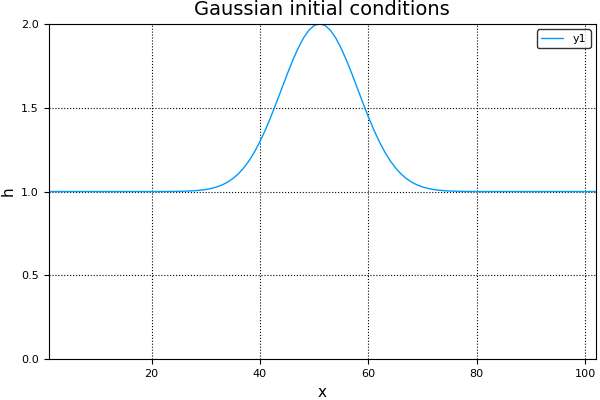

In [7]:
function gaussian_ics(ncells::Int)
    mid = ncells / 2.0 + 1
    qs = Array{Q,1}(ncells+2)
    for x = 1:ncells+2
        pos_rel = (mid-x) / (ncells/10.0)
        qs[x] = Q(exp(-pos_rel^2) + 1, 0.0)
    end
    return qs
end

plot(map(x->x.h, gaussian_ics(100)), title="Gaussian initial conditions", xlabel="x", ylabel="h", ylim=(0.,2))


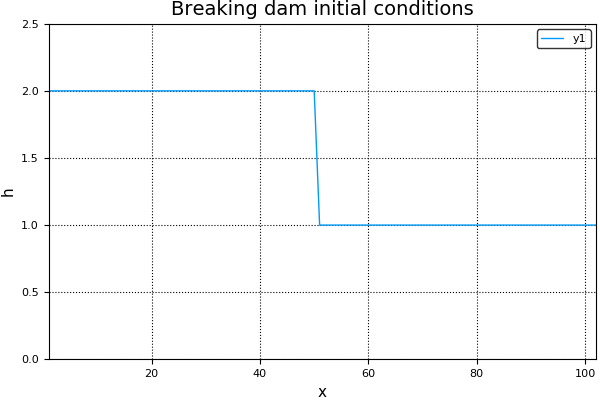

In [8]:
function breakingdam_ics(ncells::Int, h_l=2.0, h_r=1.0)
    [(x < ncells/2 + 1) ? Q(h_l,0.0) : Q(h_r,0.0) for x in 1:ncells+2]
end

plot(map(x->x.h, breakingdam_ics(100)), title="Breaking dam initial conditions", xlabel="x", ylabel="h", ylim=(0.,2.5))

In [9]:

function outflow_bcs(qs::Array{Q,1})
    qs[1] = qs[2]
    qs[end] = qs[end-1]
end

function periodic_bcs(qs::Array{Q,1})
    qs[1] = qs[end-1]
    qs[end] = qs[2]
end


periodic_bcs (generic function with 1 method)


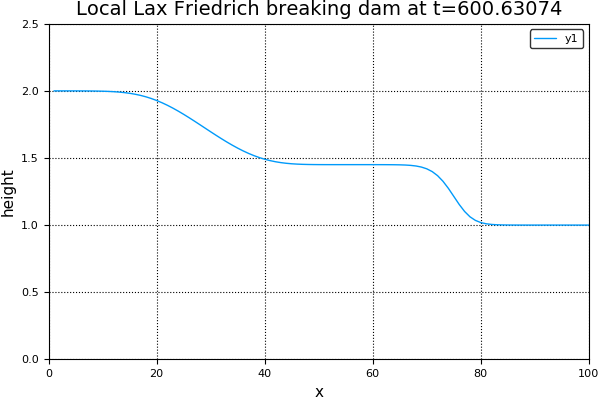

In [20]:
qs,t,ts = run_experiment(600, 100, true, outflow_bcs, breakingdam_ics)
plot(map(q -> q.h, qs[2:end-1]), title="Local Lax Friedrich breaking dam at t=$t", 
                                 xlims = (0,100), ylims = (0.0,2.5),
                                 xlabel="x", ylabel="height")


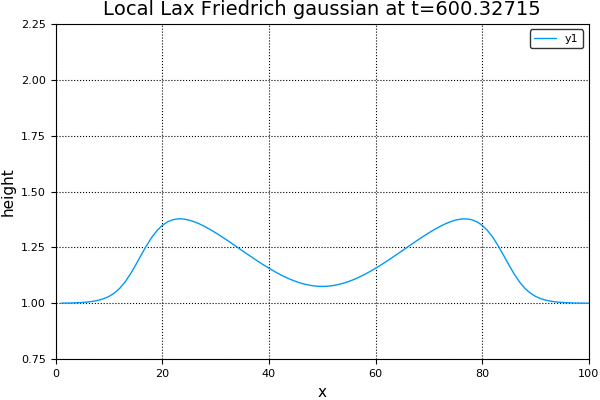

In [13]:
qs,t,ts = run_experiment(600, 100, true, periodic_bcs, gaussian_ics)
plot(map(q -> q.h, qs[2:end-1]), title="Local Lax Friedrich gaussian at t=$t", 
                                 xlims = (0,100), ylims = (0.75,2.25),
                                 xlabel="x", ylabel="height")